### Import Libraries

In [ ]:
# Bibliotecas RAPIDS (GPU)
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.metrics import accuracy_score, confusion_matrix

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler 
from sklearn.metrics import precision_recall_fscore_support

# Bibliotecas de Utilidades
import cupy as cp 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

# Bibliotecas TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Configuração de Memória da GPU (Crucial para 6GB VRAM)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-12-02 18:13:19.747223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio Preprocessing

In [ ]:
# Caminho para o seu arquivo CSV do GTZAN
GTZAN_CSV_PATH = '../gtzan_dataset/features_30_sec.csv'

# 1. Carregar Dados
df = pd.read_csv(GTZAN_CSV_PATH)

# 2. Limpeza
# Limpando colunas indesejáveis do GTZAN
drop_cols = ['filename', 'length', 'label'] 
# Verifique se no seu CSV as colunas tem esses nomes exatos, as vezes é 'class' ao invés de 'label'

X = df.drop(columns=[c for c in drop_cols if c in df.columns], axis=1)
y = df['label']

print(f"Shape dos dados: {X.shape}")
print(f"Colunas de features: {list(X.columns)}")

# 3. Codificar Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y).astype(np.int32)

# 4. Converter para Numpy e Float32 (Padrão RAPIDS/TF)
X_np = X.to_numpy().astype(np.float32)
y_np = y_encoded.astype(np.int32)

num_classes = len(np.unique(y_np))
print(f"Número de classes: {num_classes}")

Shape dos dados: (1000, 57)
Colunas de features: ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']
Número de classes: 10


### Treino dos Modelos

In [3]:
def build_gtzan_mlp(input_shape, num_classes):
    # Regularização um pouco mais forte pois o dataset é pequeno
    l2_reg = 0.02
    dropout_rate = 0.6
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Camada 1
        layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),

        # Camada 2
        layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 3
        layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        
        # Saída
        layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) 
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
# 1. Estratégia de Validação
# Usamos StratifiedKFold pois não temos Artist ID explícito no CSV padrão
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 2. Definição dos Pipelines
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10)) 
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=0.75, gamma='scale')) 
])

# Random Forest: n_estimators mantido, max_depth reduzido levemente
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=300, 
                                  max_depth=7,
                                  min_samples_leaf=5,
                                  max_features=0.6))
])

# XGBoost: Ajustado para dataset menor
model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.03,
    gamma=5.0,             # AUMENTADO: poda agressiva de árvores
    reg_alpha=1.0,
    reg_lambda=1.0,        # AUMENTADO: regularização L2
    subsample=0.7,         # Usa apenas 70% dos dados por árvore
    colsample_bytree=0.7,  # Usa apenas 70% das features por árvore
    tree_method='hist',
    device="cuda",
    random_state=42,
    objective='multi:softmax',
    num_class=num_classes 
)

models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (GPU)": pipe_rf,
    "XGBoost (GPU)": model_xgb,
    "MLP (Keras)": "keras_placeholder"
}

cv_scores = {}
out_of_fold_preds = {}

print(f"Iniciando treinamento com {n_splits} folds no GTZAN...")

for model_name, model in models.items():
    print(f"\nIniciando CV para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_y_true = []
    all_y_pred = []

    # Não usamos 'groups' aqui
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_np, y_np)):
        X_train, X_test = X_np[train_idx], X_np[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]

        # NÃO há Feature Selection (SelectKBest) aqui, usamos todas as features.

        y_pred_fold = None 

        if model_name == "MLP (Keras)":
            # Scaling na CPU para o TF
            scaler = SklearnStandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            keras_model = build_gtzan_mlp(X_train.shape[1], num_classes)
            
            # Callbacks
            callbacks_list = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
            ]

            history = keras_model.fit(
                X_train_scaled, y_train,
                epochs=100, # Mais épocas pois o dataset é pequeno e converge rápido
                batch_size=16, # Batch menor para generalizar melhor em dados pequenos
                validation_split=0.1,
                callbacks=callbacks_list,
                verbose=0
            )
            
            y_probs = keras_model.predict(X_test_scaled, verbose=0)
            y_pred_fold = np.argmax(y_probs, axis=1)
            
            tf.keras.backend.clear_session()
            del keras_model
            gc.collect()

        elif "(GPU)" in model_name:
            X_train_cp = cp.array(X_train)
            X_test_cp = cp.array(X_test)
            y_train_cp = cp.array(y_train)
            
            model.fit(X_train_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_cp)
            y_pred_fold = cp.asnumpy(y_pred_cp)

            # Fazer a predição nos dados de TREINO que acabamos de usar
            y_pred_train_cp = model.predict(cp.array(X_train))
            y_pred_train = cp.asnumpy(y_pred_train_cp)
            # Calcular acurácia de treino
            acc_train = accuracy_score(y_train, y_pred_train)

            print(f"Fold {fold} - {model_name} - Treino: {acc_train:.4f}")

            
            del X_train_cp, X_test_cp, y_train_cp

        # Métricas
        acc = accuracy_score(y_test, y_pred_fold)
        fold_scores_acc.append(acc)
        
        # Calculo dos precision_recall_fscore_support
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_fold, average='macro', zero_division=0)

        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))
        
        
        all_y_true.append(y_test)
        all_y_pred.append(y_pred_fold)
    
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_y_true),
        'y_pred': np.concatenate(all_y_pred)
    }
    
    # Limpeza
    gc.collect()
    try:
        cp.get_default_memory_pool().free_all_blocks()
    except:
        pass

print("\n--- Avaliação Concluída ---")

Iniciando treinamento com 10 folds no GTZAN...

Iniciando CV para KNN (GPU)...
Fold 0 - KNN (GPU) - Treino: 0.7522
Fold 1 - KNN (GPU) - Treino: 0.7522
Fold 2 - KNN (GPU) - Treino: 0.7522
Fold 3 - KNN (GPU) - Treino: 0.7589
Fold 4 - KNN (GPU) - Treino: 0.7611
Fold 5 - KNN (GPU) - Treino: 0.7511
Fold 6 - KNN (GPU) - Treino: 0.7511
Fold 7 - KNN (GPU) - Treino: 0.7478
Fold 8 - KNN (GPU) - Treino: 0.7556
Fold 9 - KNN (GPU) - Treino: 0.7622

Iniciando CV para SVM (GPU)...
Fold 0 - SVM (GPU) - Treino: 0.8744
Fold 1 - SVM (GPU) - Treino: 0.8789
Fold 2 - SVM (GPU) - Treino: 0.8756
Fold 3 - SVM (GPU) - Treino: 0.8822
Fold 4 - SVM (GPU) - Treino: 0.8733
Fold 5 - SVM (GPU) - Treino: 0.8778
Fold 6 - SVM (GPU) - Treino: 0.8722
Fold 7 - SVM (GPU) - Treino: 0.8767
Fold 8 - SVM (GPU) - Treino: 0.8767
Fold 9 - SVM (GPU) - Treino: 0.8811

Iniciando CV para Random Forest (GPU)...
Fold 0 - Random Forest (GPU) - Treino: 0.8867
Fold 1 - Random Forest (GPU) - Treino: 0.8833
Fold 2 - Random Forest (GPU) - Trei

### Análise de Resultados


========= KNN (GPU) =========
Acurácia       : Média 0.6720 | Std 0.0435
Precisão       : Média 0.7024 | Std 0.0349
Recall         : Média 0.6720 | Std 0.0435
F1-Score       : Média 0.6702 | Std 0.0436

========= SVM (GPU) =========
Acurácia       : Média 0.7280 | Std 0.0567
Precisão       : Média 0.7431 | Std 0.0550
Recall         : Média 0.7280 | Std 0.0567
F1-Score       : Média 0.7262 | Std 0.0590

========= Random Forest (GPU) =========
Acurácia       : Média 0.6520 | Std 0.0417
Precisão       : Média 0.6597 | Std 0.0427
Recall         : Média 0.6520 | Std 0.0417
F1-Score       : Média 0.6442 | Std 0.0465

========= XGBoost (GPU) =========
Acurácia       : Média 0.6540 | Std 0.0474
Precisão       : Média 0.6579 | Std 0.0427
Recall         : Média 0.6540 | Std 0.0474
F1-Score       : Média 0.6477 | Std 0.0460

========= MLP (Keras) =========
Acurácia       : Média 0.6500 | Std 0.0335
Precisão       : Média 0.5946 | Std 0.0318
Recall         : Média 0.6500 | Std 0.0335
F1-Score    

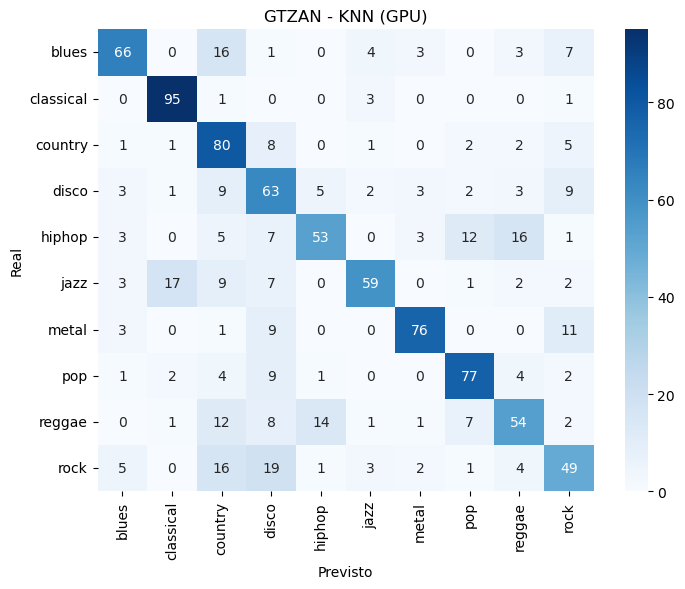

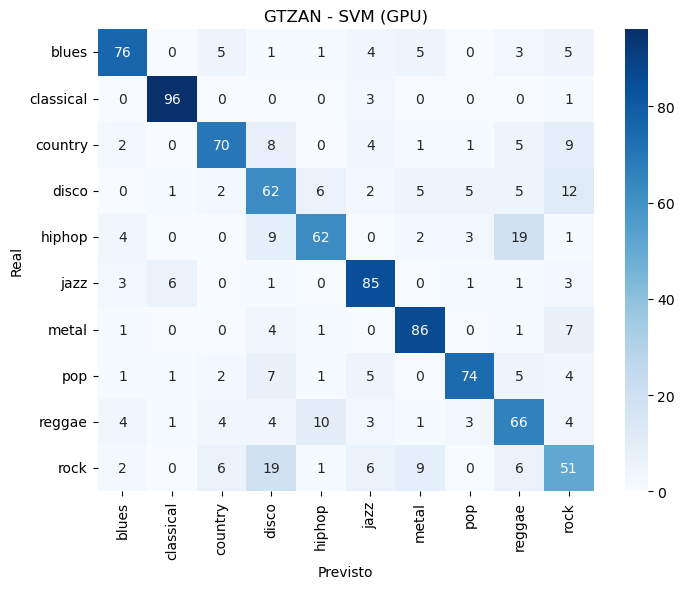

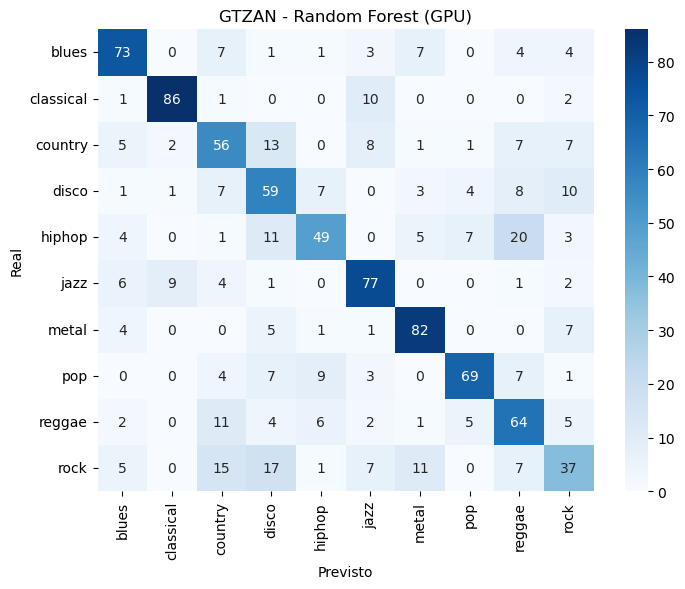

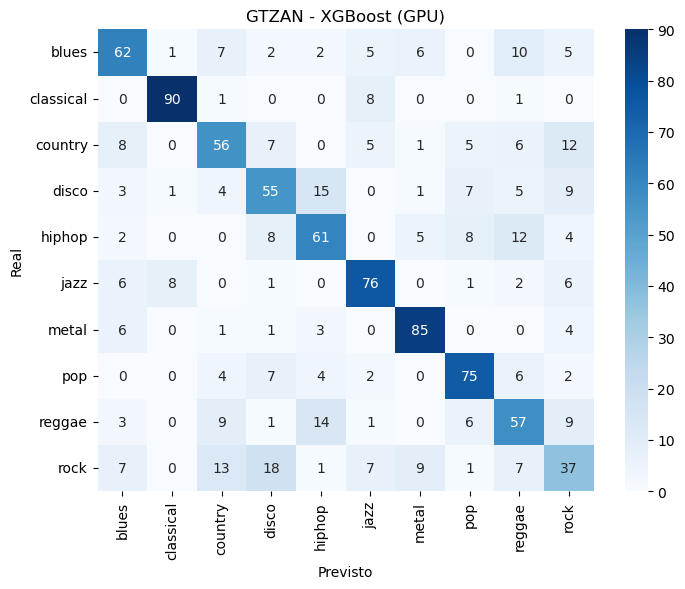

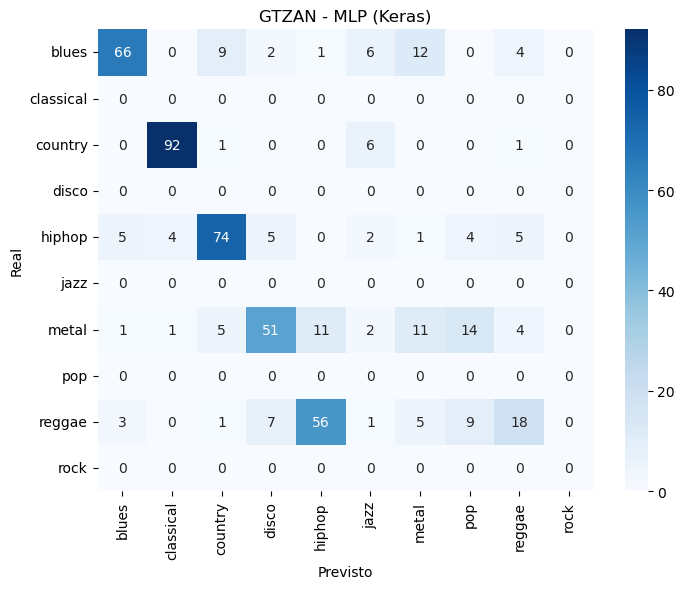

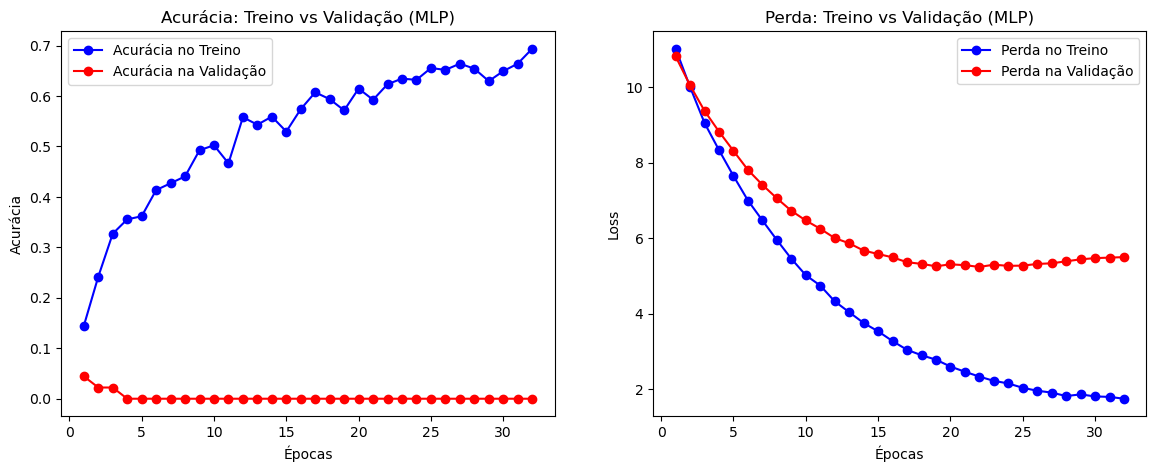

In [5]:
for model_name, metrics in cv_scores.items():
    print(f"\n========= {model_name} =========")
    for metric_name, values in metrics.items():
        print(f"{metric_name:15}: Média {values.mean():.4f} | Std {values.std():.4f}")

# Plot Matriz de Confusão
class_names = label_encoder.classes_

for model_name, results in out_of_fold_preds.items():
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    if hasattr(cm, 'get'): cm = cm.get() # Se for cupy, move para numpy
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'GTZAN - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()

# MLP Treining Measurement
if 'history' in locals():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Acurácia no Treino')     # Linha Azul
    plt.plot(epochs, val_acc, 'ro-', label='Acurácia na Validação') # Linha Vermelha
    plt.title('Acurácia: Treino vs Validação (MLP)')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Perda no Treino')
    plt.plot(epochs, val_loss, 'ro-', label='Perda na Validação')
    plt.title('Perda: Treino vs Validação (MLP)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
else:
    print("A variável 'history' não foi encontrada. Certifique-se de ter rodado o treino do MLP.")